<p align="center">
  <b>VELIB Data Science Analysis</b><br>
  Name: Victor Hugo Ribeiro Leite Da Silva<br>
  E-mail: victorhugo.ribeiro@telecom-paris.fr<br>
  Phone: +33 07 49 85 76 43
</p>

### Summary of my approach

In this analysis, I explore the VELIB dataset through data cleaning, feature engineering, and modeling stages.  
The goal is to uncover insights about bike usage patterns and develop predictive models that optimize resource allocation.

- Data Analysis  
- Data Cleaning  
- Feature Engineering  
- Modeling


In [18]:
#API to take the data for every 10 minutes

def coletar_e_append_velib():
    url = "https://opendata.paris.fr/api/records/1.0/search/"
    params = {
        "dataset": "velib-disponibilite-en-temps-reel",
        "rows": 1500
    }
    response = requests.get(url, params=params)
    data = response.json()

    records = [r['fields'] for r in data['records']]
    df = pd.DataFrame(records)

    # Adiciona timestamp da coleta
    df['timestamp_coleta'] = datetime.now()

    # Append ao arquivo CSV existente
    # Se o arquivo não existir, ele será criado
    df.to_csv("velib_historico.csv", mode='a', header=not os.path.exists("velib_historico.csv"), index=False)
    print("Dados adicionados ao velib_historico.csv")

# Para rodar constantemente, descomente:
while True:
     coletar_e_append_velib()
     time.sleep(3)  # 10 minutos


Dados adicionados ao velib_historico.csv


KeyboardInterrupt: 

## Importing Libraries and Datasets

### Libraries

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point

import geopandas as gpd
import requests
from datetime import datetime, timedelta
import time
import os



pd.set_option('display.max_columns', None) #Show all columns

### Datasets

In [2]:
df = pd.read_csv( 'velib-disponibilite-en-temps-reel.csv', sep = ';')
df.head()

,Identifiant station,Nom station,Station en fonctionnement,Capacité de la station,Nombre bornettes libres,Nombre total vélos disponibles,Vélos mécaniques disponibles,Vélos électriques disponibles,Borne de paiement disponible,Retour vélib possible,Actualisation de la donnée,Coordonnées géographiques,Nom communes équipées,Code INSEE communes équipées,station_opening_hours
0,16107,Benjamin Godard - Victor Hugo,OUI,35,29,5,1,4,OUI,OUI,2025-10-18T18:37:02+02:00,"48.865983, 2.275725",Paris,75056,NaN
1,32304,Charcot - Benfleet,OUI,28,25,1,0,1,OUI,OUI,2025-10-18T18:38:01+02:00,"48.878370277021, 2.440523876268",Romainville,93063,NaN
2,40001,Hôpital Mondor,OUI,28,9,18,10,8,OUI,OUI,2025-10-18T18:40:10+02:00,"48.798922410229, 2.4537451531298",Créteil,94028,NaN
3,14111,Cassini - Denfert-Rochereau,OUI,25,21,2,1,1,OUI,OUI,2025-10-18T18:39:09+02:00,"48.837525839067, 2.3360354080796",Paris,75056,NaN
4,9020,Toudouze - Clauzel,OUI,21,18,3,1,2,OUI,OUI,2025-10-18T18:36:44+02:00,"48.87929591733507, 2.3373600840568547",Paris,75056,NaN


### Data Analysis

Getting the main info to train the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1495 entries, 0 to 1494
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Identifiant station             1495 non-null   int64  
 1   Nom station                     1495 non-null   object 
 2   Station en fonctionnement       1495 non-null   object 
 3   Capacité de la station          1495 non-null   int64  
 4   Nombre bornettes libres         1495 non-null   int64  
 5   Nombre total vélos disponibles  1495 non-null   int64  
 6   Vélos mécaniques disponibles    1495 non-null   int64  
 7   Vélos électriques disponibles   1495 non-null   int64  
 8   Borne de paiement disponible    1495 non-null   object 
 9   Retour vélib possible           1495 non-null   object 
 10  Actualisation de la donnée      1495 non-null   object 
 11  Coordonnées géographiques       1495 non-null   object 
 12  Nom communes équipées           14

Checking number of NA on the dataset

In [4]:
df.isna().sum()

Identifiant station                  0
Nom station                          0
Station en fonctionnement            0
Capacité de la station               0
Nombre bornettes libres              0
Nombre total vélos disponibles       0
Vélos mécaniques disponibles         0
Vélos électriques disponibles        0
Borne de paiement disponible         0
Retour vélib possible                0
Actualisation de la donnée           0
Coordonnées géographiques            0
Nom communes équipées                0
Code INSEE communes équipées         0
station_opening_hours             1495
dtype: int64

Since the column 'station_opening_hours' has all values NA, i will consider that ALL stations are always open. Thus, i will drop this column

In [5]:
df = df.drop(['station_opening_hours'], axis = 1) 

--- 

### Before making any analysis, it is important to understand the two stations i want to work on

Since i always do the same 10km traject by bike and need these 2 stations to be free, i will load paris map and show the exact location of them using the coordinates of velib dataset

<Axes: >

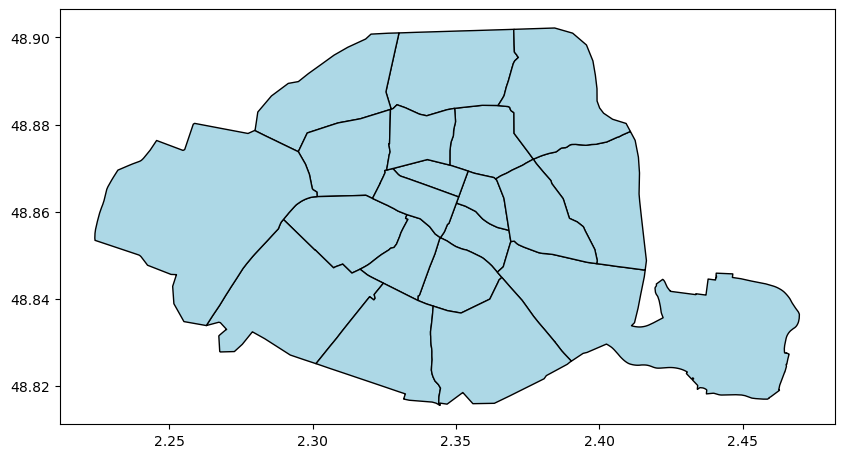

In [7]:
# Load Paris map shapefile or GeoJSON
paris_map = gpd.read_file("arrondissements/arrondissements.shp")
paris_map.plot(figsize=(10, 10), edgecolor='black', color='lightblue')

/var/folders/tz/tl_w5k6s62vcg00cl2mjjbtc0000gn/T/ipykernel_94876/190097045.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  paris_map.centroid.plot(ax=ax, color='red', marker='o')


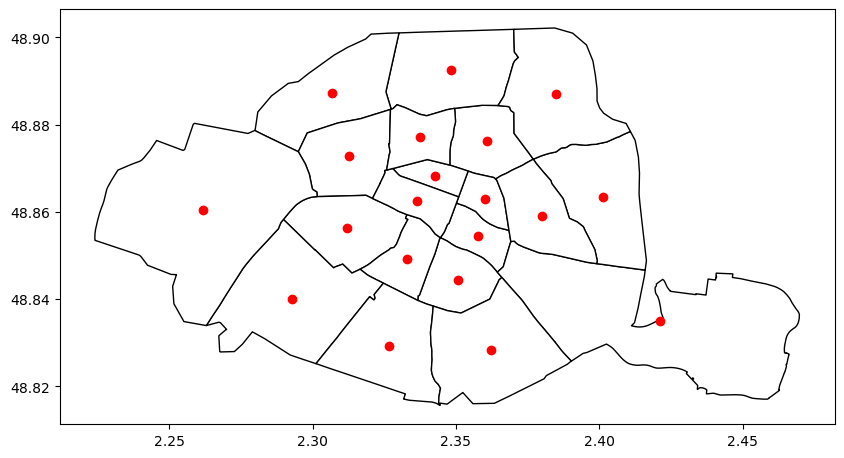

In [ ]:
# all the arrondissements of Paris

fig, ax = plt.subplots(figsize=(10, 10))
paris_map.plot(ax=ax, color='white', edgecolor='black')
paris_map.centroid.plot(ax=ax, color='red', marker='o')
plt.show()

### By looking on the official website i can verify that the 2 stations i use the most are:

- Jourdan - Monticelli 
- Porte Dauphine

These are the stations I use everyday to leave cite universitaire and get to Dauphine. So since they are the most importants for me, i will use them as a base and take their information from my dataset

In [ ]:
# Geographic Coordenates

stations = df[  df['Nom station'].isin(['Porte Dauphine', 'Jourdan - Monticelli'])  ]
stations['Coordonnées géographiques']


770                  48.822032, 2.329095
1089    48.871139344351, 2.2749781616017
Name: Coordonnées géographiques, dtype: object

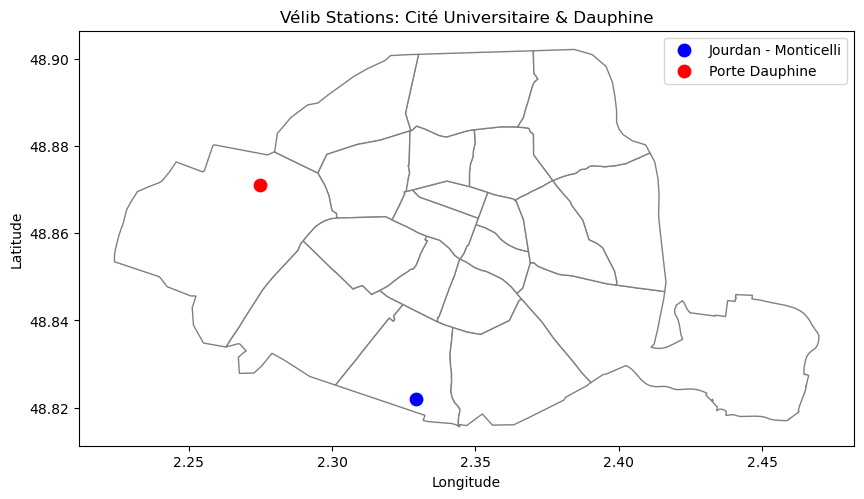

In [ ]:
# Putting these points on the map

data = {
    'station': ['Jourdan - Monticelli', 'Porte Dauphine'],
    'lat': [48.822032, 48.871139],
    'lon': [2.329095, 2.274978],
    'color': ['blue', 'red']  
}

# Creates GeoDataFrame
stations = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['lon'], data['lat']),
    crs="EPSG:4326"
)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
paris_map.to_crs(epsg=4326).plot(ax=ax, color='white', edgecolor='gray')

# Add points
for i, row in stations.iterrows():
    ax.scatter(row.geometry.x, row.geometry.y, color=row.color, s=80, label=row.station)

# Config 
ax.legend()
ax.set_title("Vélib Stations: Cité Universitaire & Dauphine")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

---

## The use of velib in Paris

Before giving a special attention to the two stations, i want to analyse the general use of velib

1. What are the regions of highest demand ? 
2. For every station , what is the distribution of bikes ? We usually have more eletric or mechanic ?
3. How do usage patterns vary across time (hours, days, or districts), and can we identify clusters of stations with similar temporal dynamics?

1. To determine the highest demand regions, i must verify the regions that had the most updates

For now i need to transform the column of Time and then make a groupby for every station to make sure the stations that have the most updates across time

2. For the distribu

In [ ]:
demand_regions = df.groupby('Nom station')['Actualisation de la donnée'].count()
demand_regions

Nom station
11 Novembre 1918 - 8 Mai 1945           1
18 juin 1940 - Buzenval                 1
8 Mai 1945 - 10 Juillet 1940            1
Abbeville - Faubourg Poissonnière       1
Abbé Carton - Plantes                   1
                                       ..
Youri Gagarine - Karl Marx              1
Yves Farges - Route d'Enghien           1
ZAC des Louvresses                      1
Édouard Vaillant - Place Jean Jaurès    1
Île de la Jatte                         1
Name: Actualisation de la donnée, Length: 1491, dtype: int64

In [ ]:
df.head()

,Identifiant station,Nom station,Station en fonctionnement,Capacité de la station,Nombre bornettes libres,Nombre total vélos disponibles,Vélos mécaniques disponibles,Vélos électriques disponibles,Borne de paiement disponible,Retour vélib possible,Actualisation de la donnée,Coordonnées géographiques,Nom communes équipées,Code INSEE communes équipées
0,16107,Benjamin Godard - Victor Hugo,OUI,35,29,5,1,4,OUI,OUI,2025-10-18T18:37:02+02:00,"48.865983, 2.275725",Paris,75056
1,32304,Charcot - Benfleet,OUI,28,25,1,0,1,OUI,OUI,2025-10-18T18:38:01+02:00,"48.878370277021, 2.440523876268",Romainville,93063
2,40001,Hôpital Mondor,OUI,28,9,18,10,8,OUI,OUI,2025-10-18T18:40:10+02:00,"48.798922410229, 2.4537451531298",Créteil,94028
3,14111,Cassini - Denfert-Rochereau,OUI,25,21,2,1,1,OUI,OUI,2025-10-18T18:39:09+02:00,"48.837525839067, 2.3360354080796",Paris,75056
4,9020,Toudouze - Clauzel,OUI,21,18,3,1,2,OUI,OUI,2025-10-18T18:36:44+02:00,"48.87929591733507, 2.3373600840568547",Paris,75056
